In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

from src_inference1.data import ContrailsDatasetV0, get_aug
from src_inference1.utils import seed_everything

seed_everything(2023)

/workspace/2nd-place-contrails/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. データセット読み込み

In [2]:
# データセット初期化
ds_train = ContrailsDatasetV0("../data/", train=True, tfms=None, size=5)
ds_val = ContrailsDatasetV0("../data", train=False, tfms=None, size=5)

print(f"訓練データ数: {len(ds_train)}")
print(f"検証データ数: {len(ds_val)}")

訓練データ数: 5
検証データ数: 5


## 2. 入力データの可視化

入力は偽色画像(False Color Image)で構成される。
- R: band_15 - band_14 (TDIFF)
- G: band_14 - band_11 (CLOUD_TOP_TDIFF)
- B: band_14 (T11)

時系列5フレーム分のデータが入力される。

In [3]:
# サンプルデータ取得
sample_idx = 0
img, mask = ds_train[sample_idx]

print(f"入力形状: {img.shape}")  # (3, 5, 256, 256)
print(f"マスク形状: {mask.shape}")  # (1, 256, 256)
print(f"入力値範囲: [{img.min():.3f}, {img.max():.3f}]")
print(f"マスク値範囲: [{mask.min():.3f}, {mask.max():.3f}]")

入力形状: torch.Size([3, 5, 256, 256])
マスク形状: torch.Size([1, 256, 256])
入力値範囲: [0.000, 0.945]
マスク値範囲: [0.000, 0.000]


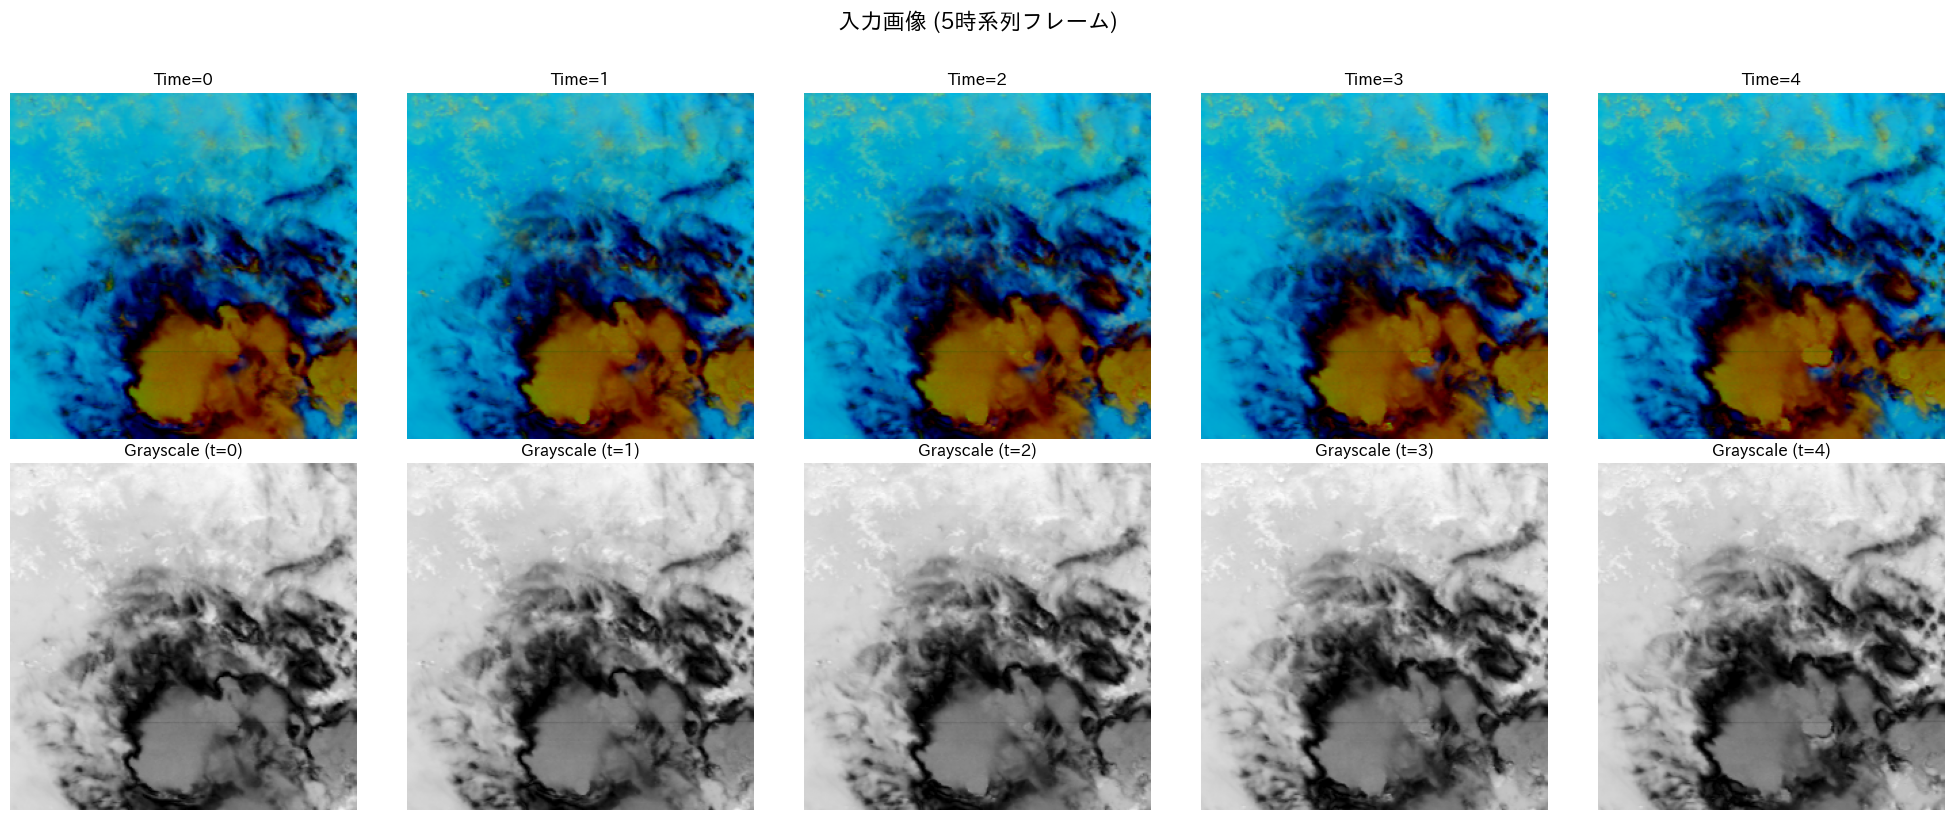

In [4]:
# 時系列フレームの可視化
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('入力画像 (5時系列フレーム)', fontsize=16, y=1.02)

for t in range(5):
    # RGB画像 (C, H, W) -> (H, W, C)
    rgb_img = img[:, t, :, :].permute(1, 2, 0).numpy()
    rgb_img = np.clip(rgb_img, 0, 1)
    
    # カラー画像
    axes[0, t].imshow(rgb_img)
    axes[0, t].set_title(f'Time={t}')
    axes[0, t].axis('off')
    
    # グレースケール (輝度)
    gray_img = rgb_img.mean(axis=2)
    axes[1, t].imshow(gray_img, cmap='gray')
    axes[1, t].set_title(f'Grayscale (t={t})')
    axes[1, t].axis('off')

plt.tight_layout()
plt.show()

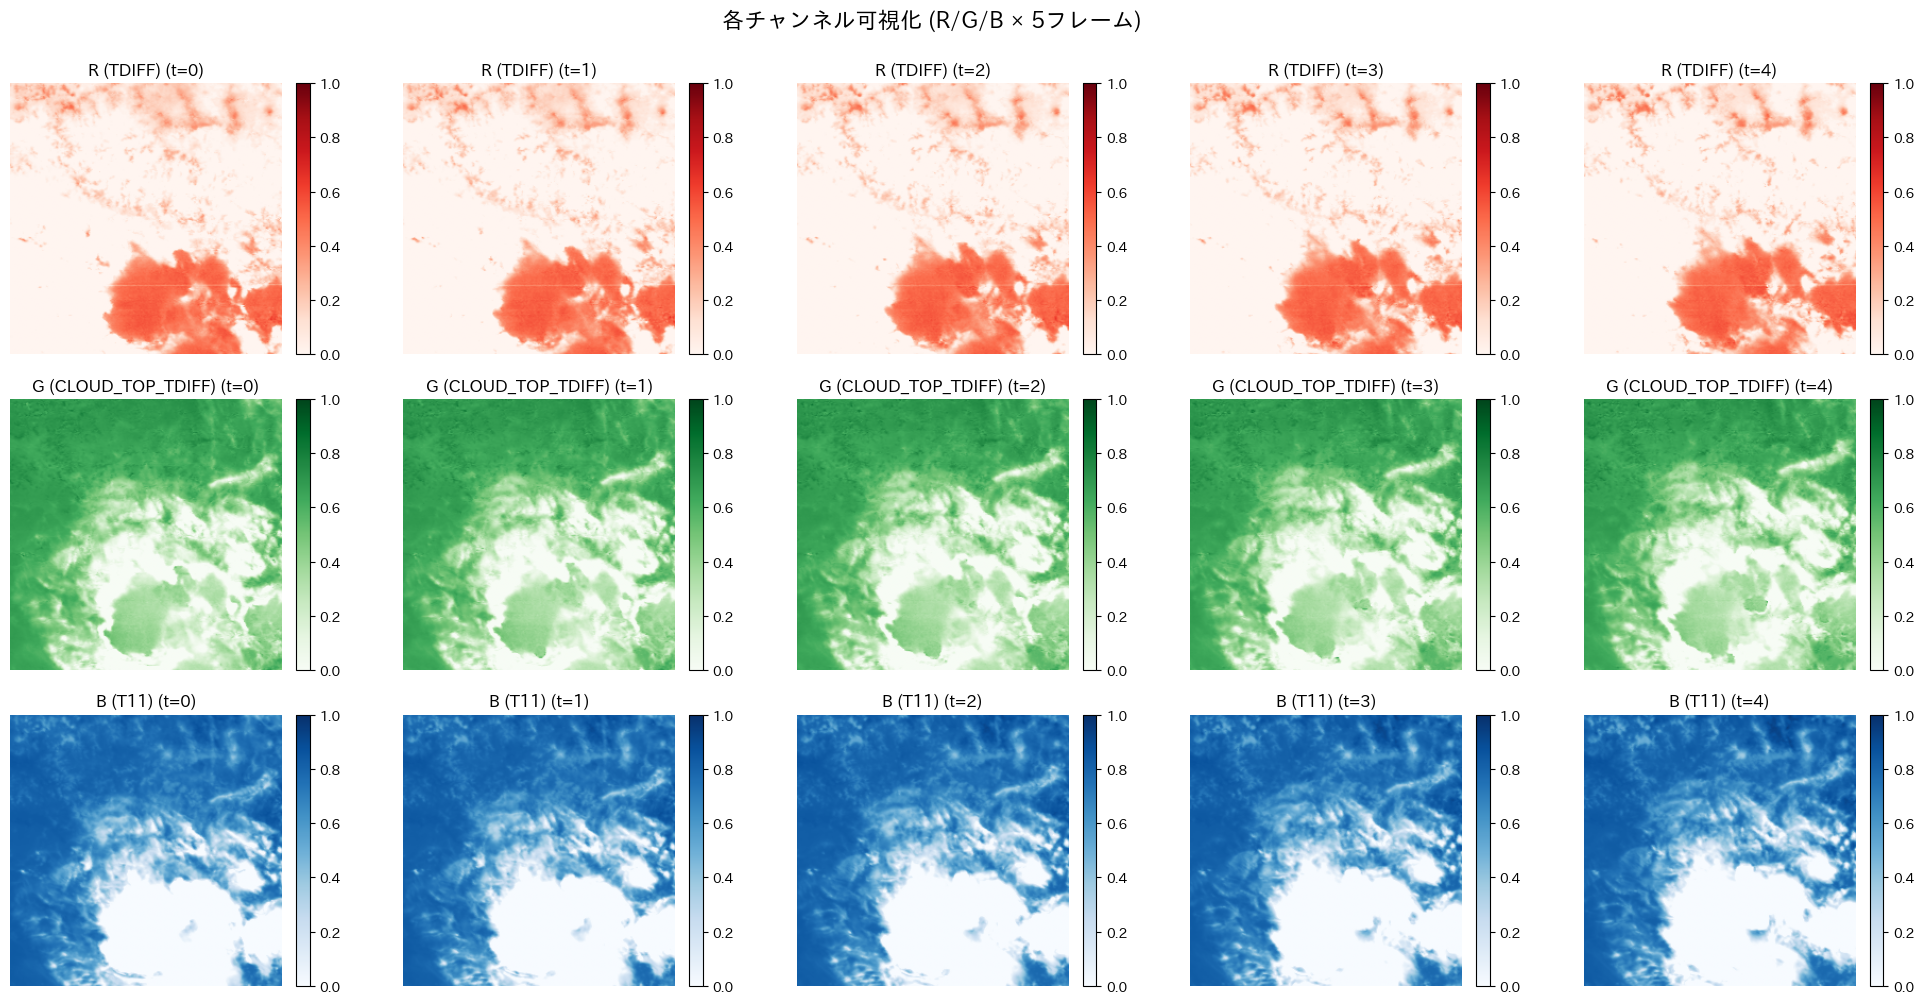

In [5]:
# 各チャンネルの可視化
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle('各チャンネル可視化 (R/G/B × 5フレーム)', fontsize=16, y=1.0)

channel_names = ['R (TDIFF)', 'G (CLOUD_TOP_TDIFF)', 'B (T11)']
cmaps = ['Reds', 'Greens', 'Blues']

for c in range(3):
    for t in range(5):
        channel_img = img[c, t, :, :].numpy()
        im = axes[c, t].imshow(channel_img, cmap=cmaps[c], vmin=0, vmax=1)
        axes[c, t].set_title(f'{channel_names[c]} (t={t})')
        axes[c, t].axis('off')
        plt.colorbar(im, ax=axes[c, t], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 3. Ground Truth マスクの可視化

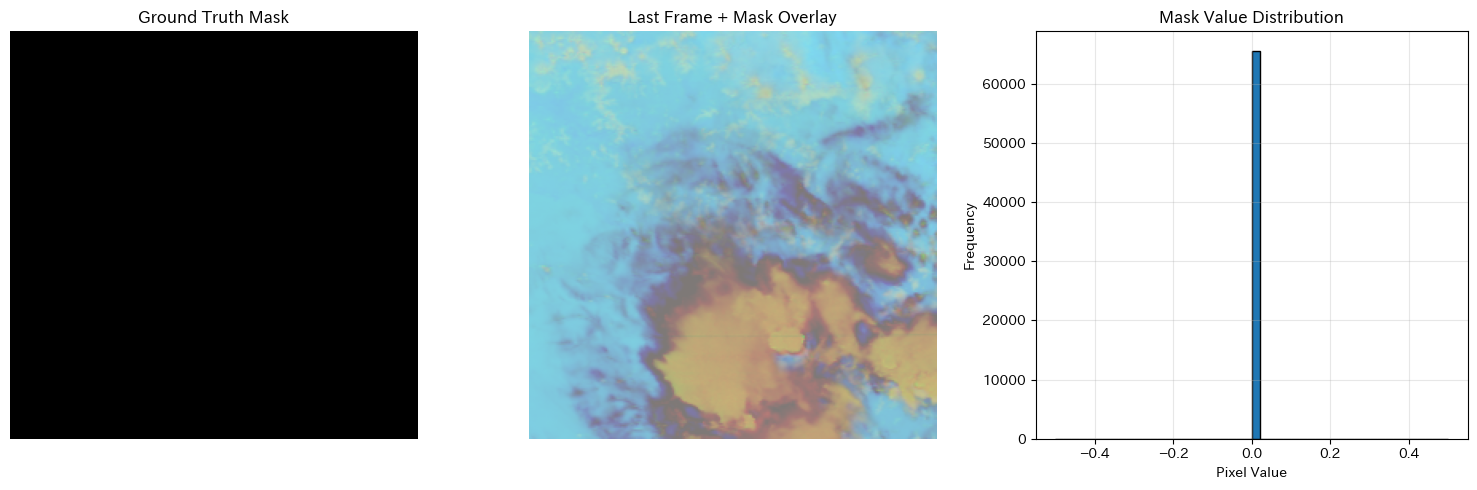

マスク内の飛行機雲領域: 0.00%


In [6]:
# マスクの可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# オリジナルマスク
mask_np = mask[0].numpy()
axes[0].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Ground Truth Mask')
axes[0].axis('off')

# 最後のフレームとマスクの重ね合わせ
last_frame = img[:, -1, :, :].permute(1, 2, 0).numpy()
last_frame = np.clip(last_frame, 0, 1)
axes[1].imshow(last_frame)
axes[1].imshow(mask_np, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axes[1].set_title('Last Frame + Mask Overlay')
axes[1].axis('off')

# マスクの統計
axes[2].hist(mask_np.flatten(), bins=50, edgecolor='black')
axes[2].set_title('Mask Value Distribution')
axes[2].set_xlabel('Pixel Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"マスク内の飛行機雲領域: {(mask_np > 0.5).sum() / mask_np.size * 100:.2f}%")

## 4. モデル推論の可視化

In [7]:
from src_inference1.BaseCoatULSTM import BaseCoatULSTM
from src_inference1.ResNet18_Simple import ResNet18_Simple
from src_inference1.ResNet18_U import ResNet18_U
from src_inference1.ResNet18_ULSTM import ResNet18_ULSTM
from src_inference1.CoaT_ULSTM import CoaT_ULSTM
from src_inference1.CoaT_U import CoaT_U
from src_inference1.CoaT_Simple import CoaT_SimplerFCN, CoaT_Simple

model = CoaT_ULSTM()
model.load_state_dict(torch.load("../experiments/CoaT_ULSTM.pth"))
# model = BaseCoatULSTM()
# model.load_state_dict(torch.load("../experiments/4epochs_base.pth"))
# model = CoaT_ULSTM()
# model.load_state_dict(torch.load("../experiments/4epochs_org.pth"))
model.eval()

# 推論
with torch.no_grad():
    input_batch = img.unsqueeze(0)  # (1, 3, 5, 256, 256)
    output = model(input_batch)  # (1, 1, 256, 256)
    output_sigmoid = torch.sigmoid(output)

print(f"モデル入力形状: {input_batch.shape}")
print(f"モデル出力形状: {output.shape}")
print(f"出力値範囲 (logits): [{output.min():.3f}, {output.max():.3f}]")
print(f"出力値範囲 (sigmoid): [{output_sigmoid.min():.3f}, {output_sigmoid.max():.3f}]")

/workspace/2nd-place-contrails/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/workspace/2nd-place-contrails/.venv/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/workspace/2nd-place-contrails/eda/../src_inference1/coat.py:589: UserWarning: Overwriting coat_tiny in registry with src_inference1.coat.coat_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/workspace/2nd-place-contrails/eda/../src_inference1/coat.py:595: UserWarning: Overwriting coat_mini in registry with src_in

モデル入力形状: torch.Size([1, 3, 5, 256, 256])
モデル出力形状: torch.Size([1, 1, 256, 256])
出力値範囲 (logits): [-4.779, -2.506]
出力値範囲 (sigmoid): [0.008, 0.075]


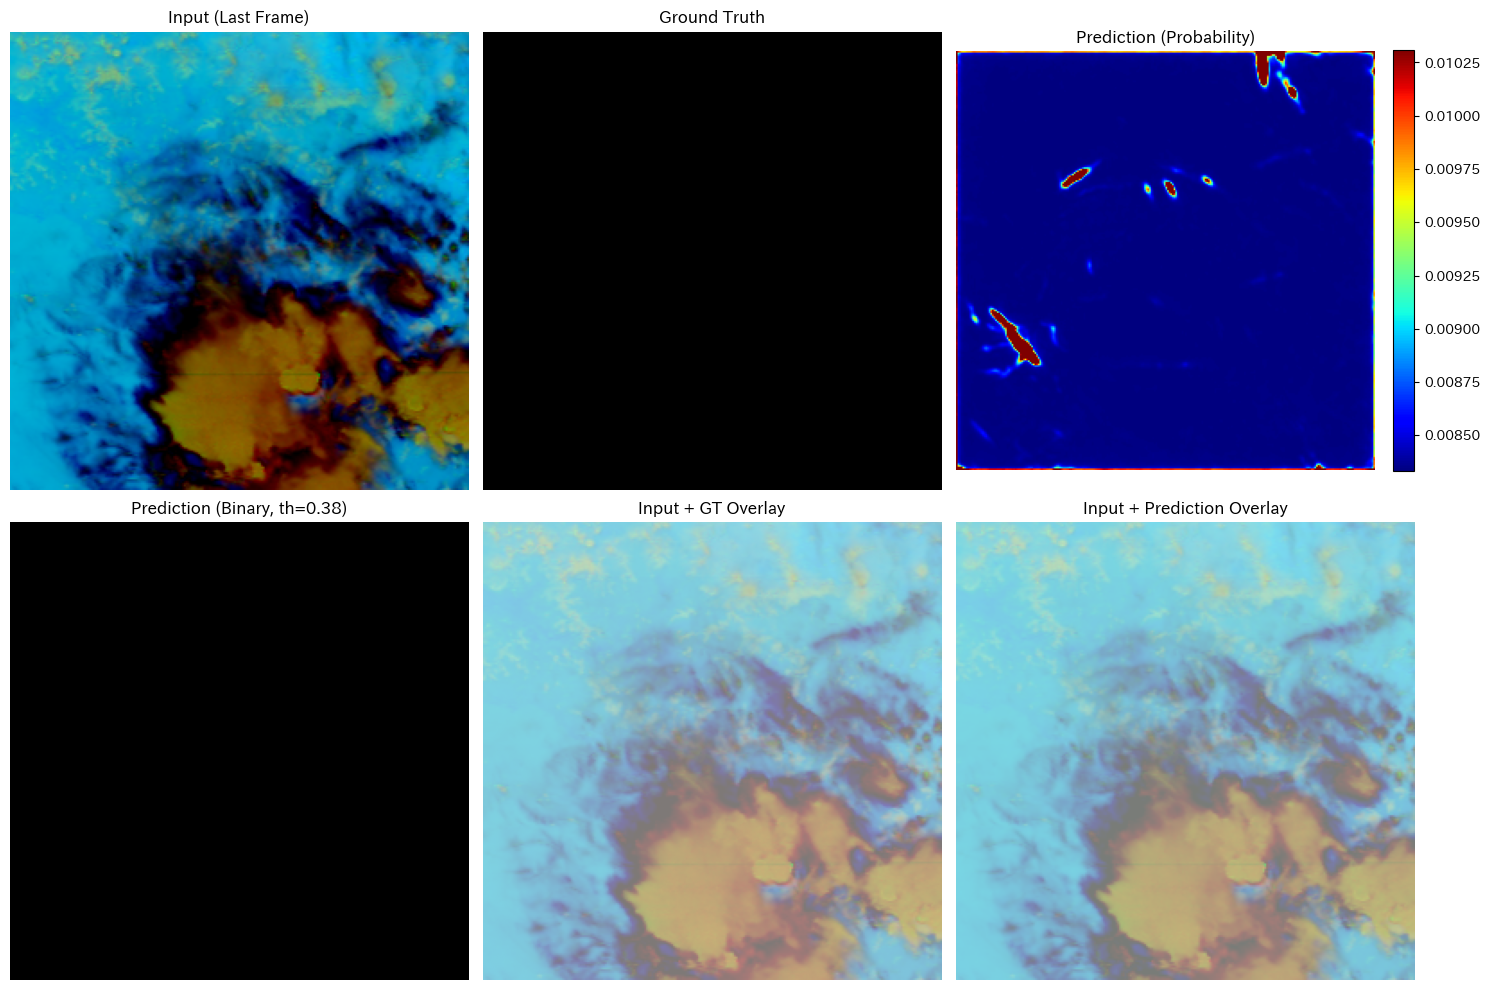

In [8]:
# 推論結果の可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

pred_np = output_sigmoid[0, 0].numpy()
pred_vmax = np.percentile(pred_np, 99)
pred_vmin = np.percentile(pred_np, 1)
pred_binary_threshold = 0.38  # np.percentile(pred_np, 95)
pred_binary = (pred_np > pred_binary_threshold).astype(np.float32)

# 入力画像 (最後のフレーム)
axes[0, 0].imshow(last_frame)
axes[0, 0].set_title('Input (Last Frame)')
axes[0, 0].axis('off')

# Ground Truth
axes[0, 1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Ground Truth')
axes[0, 1].axis('off')

# 予測 (確率)
im1 = axes[0, 2].imshow(pred_np, cmap='jet', vmin=pred_vmin, vmax=pred_vmax)
axes[0, 2].set_title('Prediction (Probability)')
axes[0, 2].axis('off')
plt.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)

# 予測 (二値化)
axes[1, 0].imshow(pred_binary, cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title(f'Prediction (Binary, th={pred_binary_threshold})')
axes[1, 0].axis('off')

# オーバーレイ (GT)
axes[1, 1].imshow(last_frame)
axes[1, 1].imshow(mask_np, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axes[1, 1].set_title('Input + GT Overlay')
axes[1, 1].axis('off')

# オーバーレイ (予測)
axes[1, 2].imshow(last_frame)
axes[1, 2].imshow(pred_np, cmap='Greens', alpha=0.5, vmin=0, vmax=1)
axes[1, 2].set_title('Input + Prediction Overlay')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 5. 複数サンプルの比較

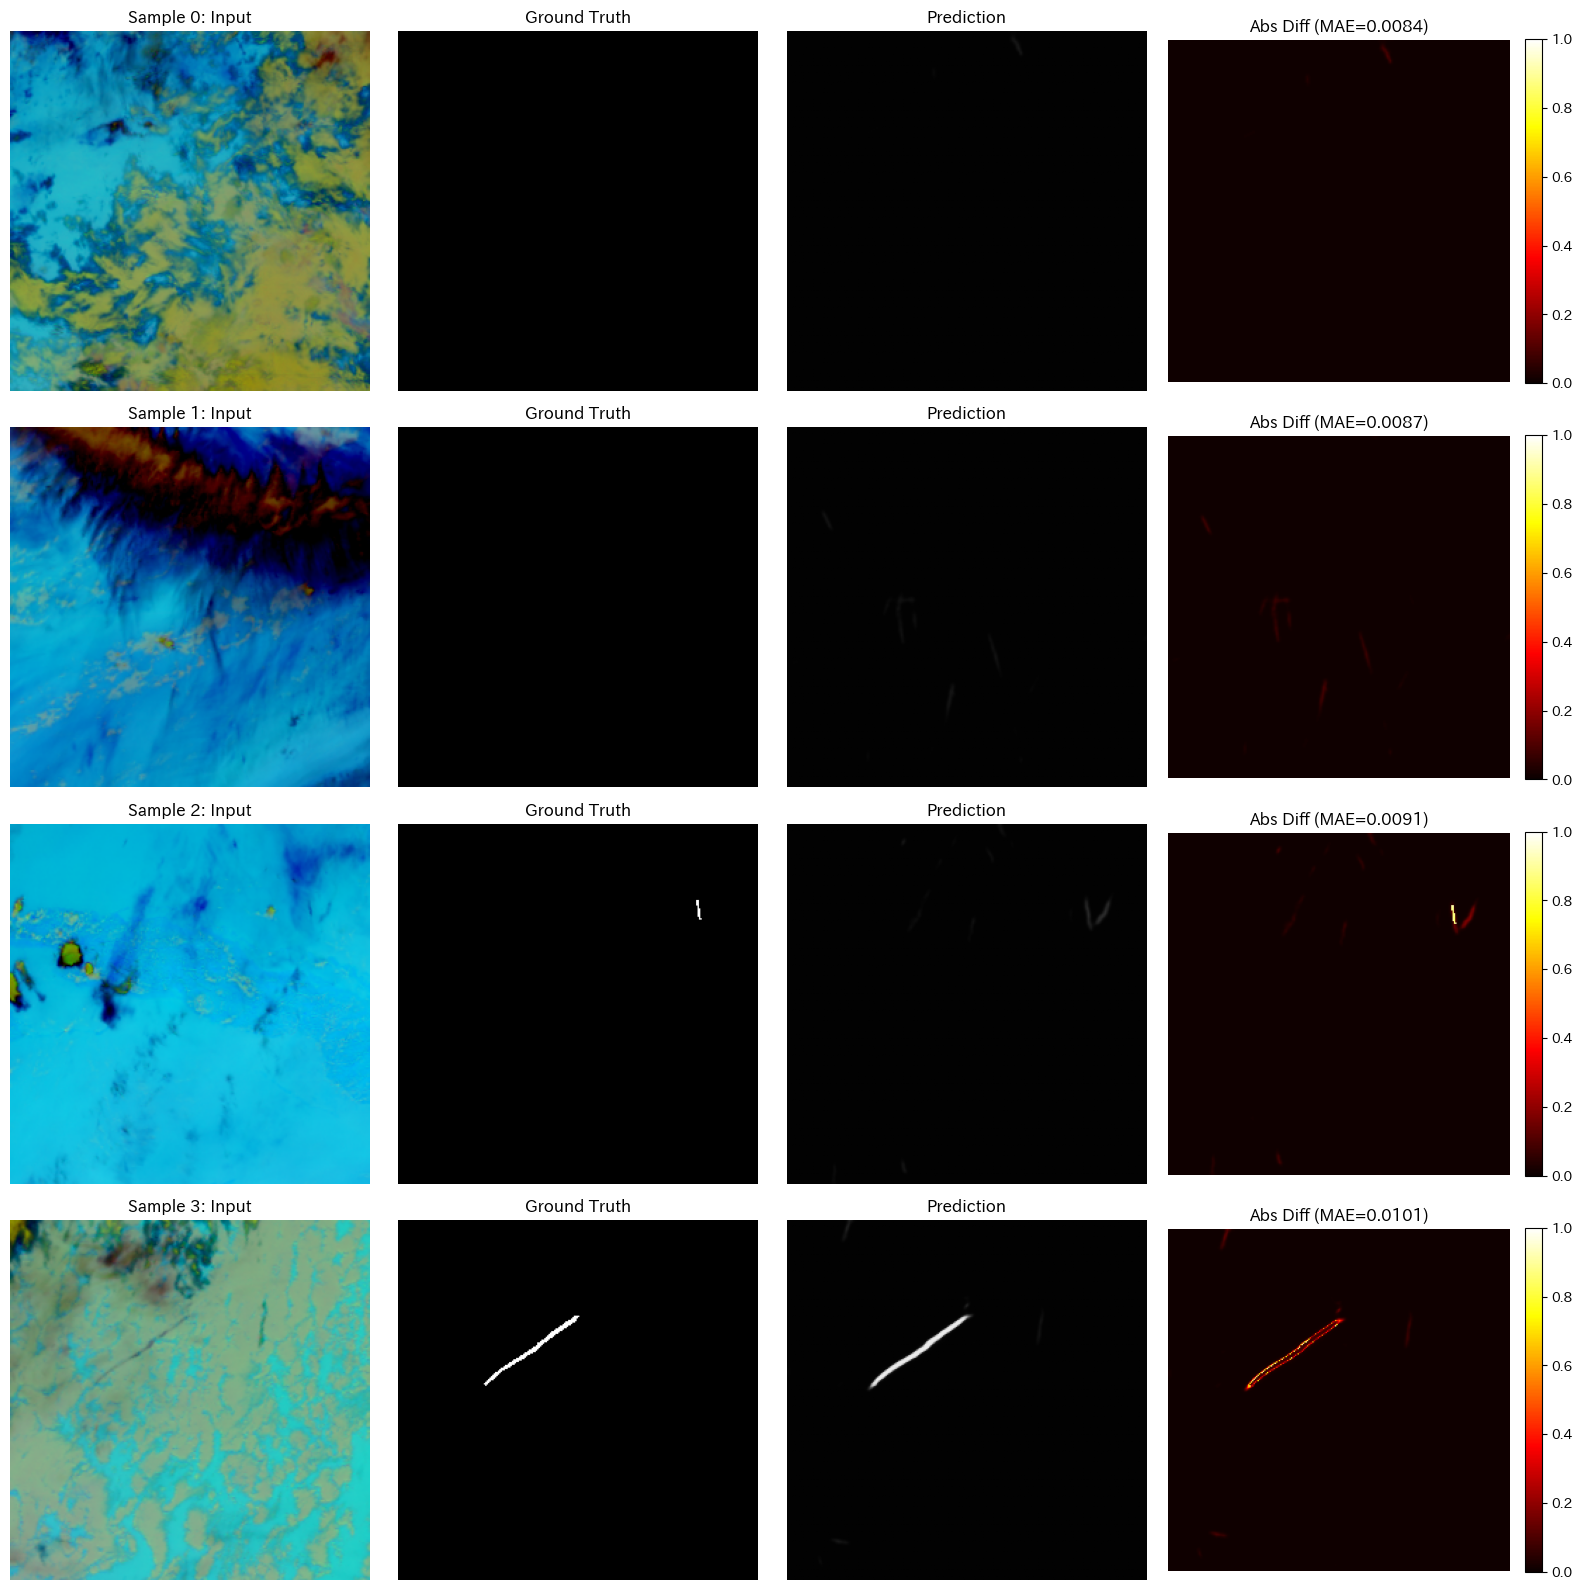

In [9]:
# 複数サンプルの可視化
num_samples = min(4, len(ds_val))
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

if num_samples == 1:
    axes = axes.reshape(1, -1)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        img, mask = ds_val[i]
        input_batch = img.unsqueeze(0)
        output = torch.sigmoid(model(input_batch))
        
        # 最後のフレーム
        last_frame = img[:, -1, :, :].permute(1, 2, 0).numpy()
        last_frame = np.clip(last_frame, 0, 1)
        
        mask_np = mask[0].numpy()
        pred_np = output[0, 0].numpy()
        
        # 入力
        axes[i, 0].imshow(last_frame)
        axes[i, 0].set_title(f'Sample {i}: Input')
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # 予測
        axes[i, 2].imshow(pred_np, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        
        # 差分
        diff = np.abs(mask_np - pred_np)
        im = axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=1)
        axes[i, 3].set_title(f'Abs Diff (MAE={diff.mean():.4f})')
        axes[i, 3].axis('off')
        plt.colorbar(im, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 6. データ拡張の効果確認

/workspace/2nd-place-contrails/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/workspace/2nd-place-contrails/eda/../src_inference1/data.py:100: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomGamma
  A.RandomGamma(gamma_limit=(50, 150), always_apply=True),
/workspace/2nd-place-contrails/eda/../src_inference1/data.py:101: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomBrightnessContrast
  A.RandomBrightnessContrast(
/workspace/2nd-place-contrails/eda/../src_inference1/data.py:109: UserWarning: Argument(s) 'always_apply' are not valid for transform MotionBlur
  A.MotionBlur(always_apply=True),
/workspace/2nd-place-contrails/eda/../src_inference1/data.py:110: UserWarning: Argument(s) 'always_apply' are not valid for transform GaussianBlur
  A.GaussianBlur(always_ap

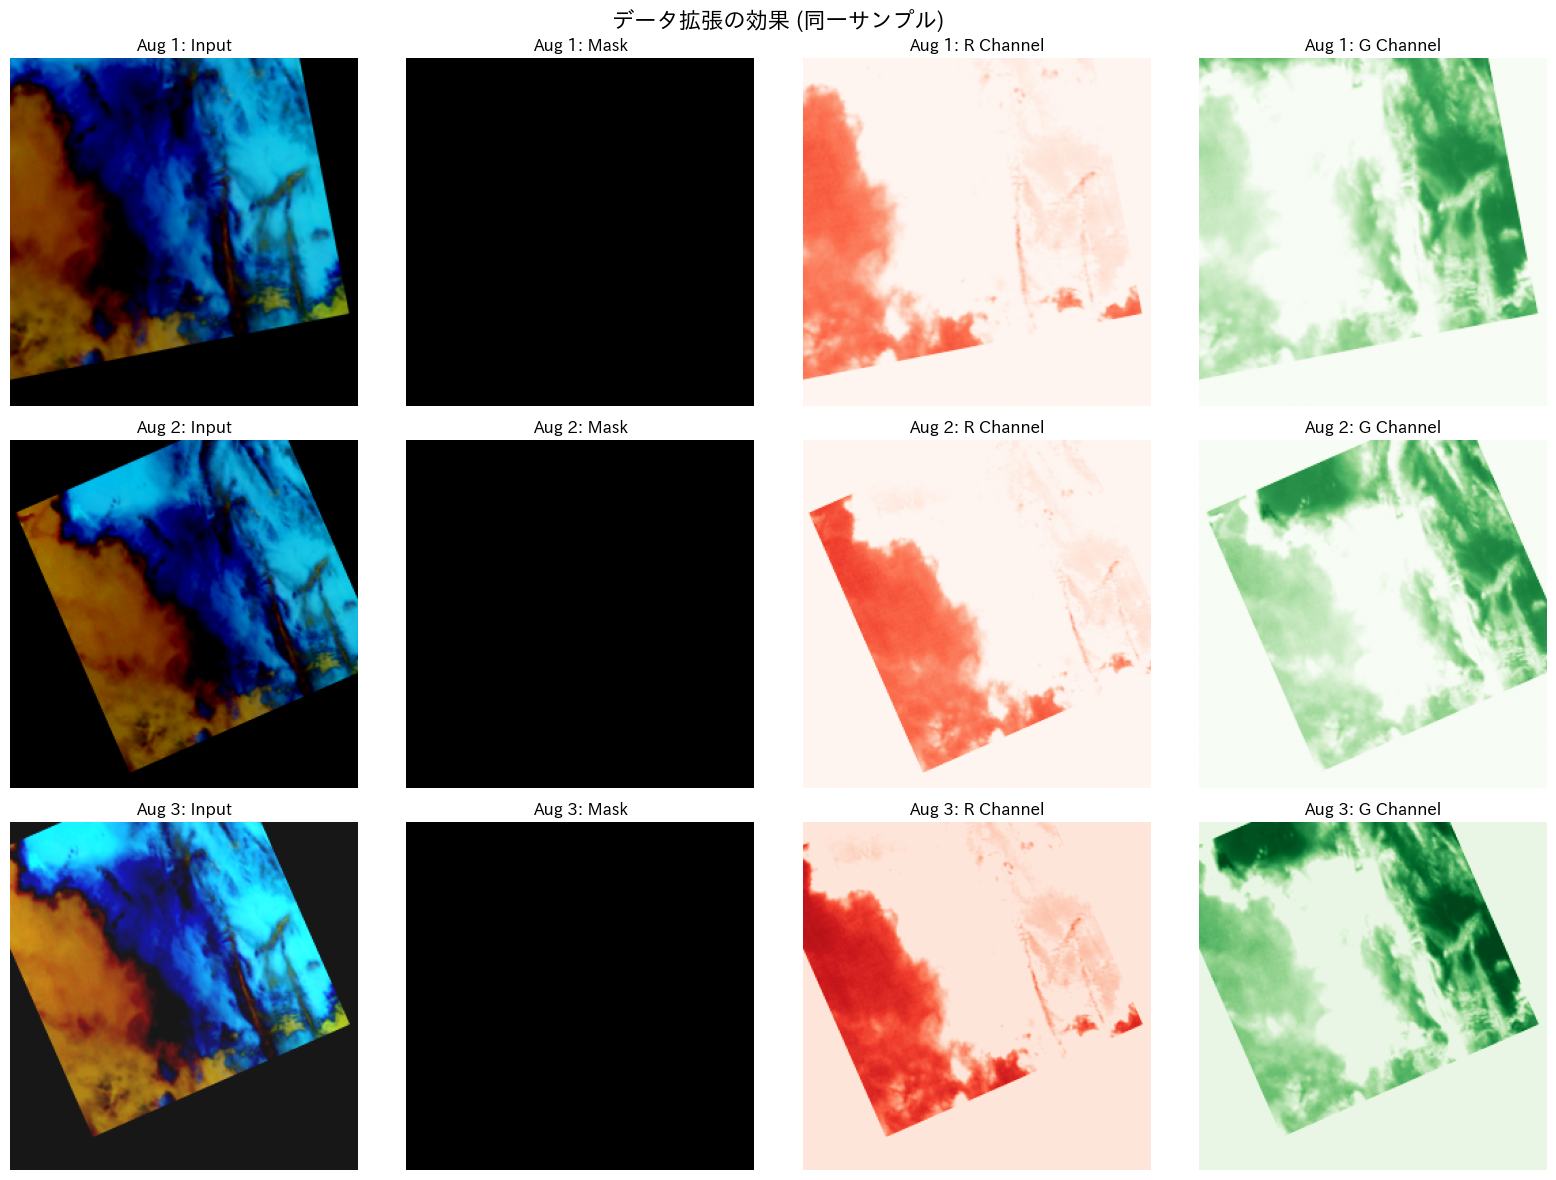

In [10]:
# データ拡張ありのデータセット
ds_train_aug = ContrailsDatasetV0("../data/", train=True, tfms=get_aug(), size=1)

# 同一サンプルでの拡張例
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('データ拡張の効果 (同一サンプル)', fontsize=16)

for i in range(3):
    img_aug, mask_aug = ds_train_aug[0]
    
    # 最後のフレーム
    last_frame_aug = img_aug[:, -1, :, :].permute(1, 2, 0).numpy()
    last_frame_aug = np.clip(last_frame_aug, 0, 1)
    mask_aug_np = mask_aug[0].numpy()
    
    # 入力画像
    axes[i, 0].imshow(last_frame_aug)
    axes[i, 0].set_title(f'Aug {i+1}: Input')
    axes[i, 0].axis('off')
    
    # マスク
    axes[i, 1].imshow(mask_aug_np, cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f'Aug {i+1}: Mask')
    axes[i, 1].axis('off')
    
    # R チャンネル
    axes[i, 2].imshow(img_aug[0, -1, :, :].numpy(), cmap='Reds', vmin=0, vmax=1)
    axes[i, 2].set_title(f'Aug {i+1}: R Channel')
    axes[i, 2].axis('off')
    
    # G チャンネル
    axes[i, 3].imshow(img_aug[1, -1, :, :].numpy(), cmap='Greens', vmin=0, vmax=1)
    axes[i, 3].set_title(f'Aug {i+1}: G Channel')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

## 7. バッチデータの統計情報

In [11]:
from torch.utils.data import DataLoader

# データローダー作成
train_loader = DataLoader(ds_train, batch_size=2, shuffle=False, num_workers=0)

# バッチ統計
batch_imgs, batch_masks = next(iter(train_loader))

print(f"バッチ入力形状: {batch_imgs.shape}")  # (2, 3, 5, 256, 256)
print(f"バッチマスク形状: {batch_masks.shape}")  # (2, 1, 256, 256)
print(f"\n入力統計:")
print(f"  平均: {batch_imgs.mean():.4f}")
print(f"  標準偏差: {batch_imgs.std():.4f}")
print(f"  最小値: {batch_imgs.min():.4f}")
print(f"  最大値: {batch_imgs.max():.4f}")
print(f"\nマスク統計:")
print(f"  平均: {batch_masks.mean():.4f}")
print(f"  標準偏差: {batch_masks.std():.4f}")
print(f"  飛行機雲領域率: {(batch_masks > 0.5).float().mean():.4f}")

バッチ入力形状: torch.Size([2, 3, 5, 256, 256])
バッチマスク形状: torch.Size([2, 1, 256, 256])

入力統計:
  平均: 0.4580
  標準偏差: 0.3566
  最小値: 0.0000
  最大値: 1.0000

マスク統計:
  平均: 0.0426
  標準偏差: 0.2019
  飛行機雲領域率: 0.0426


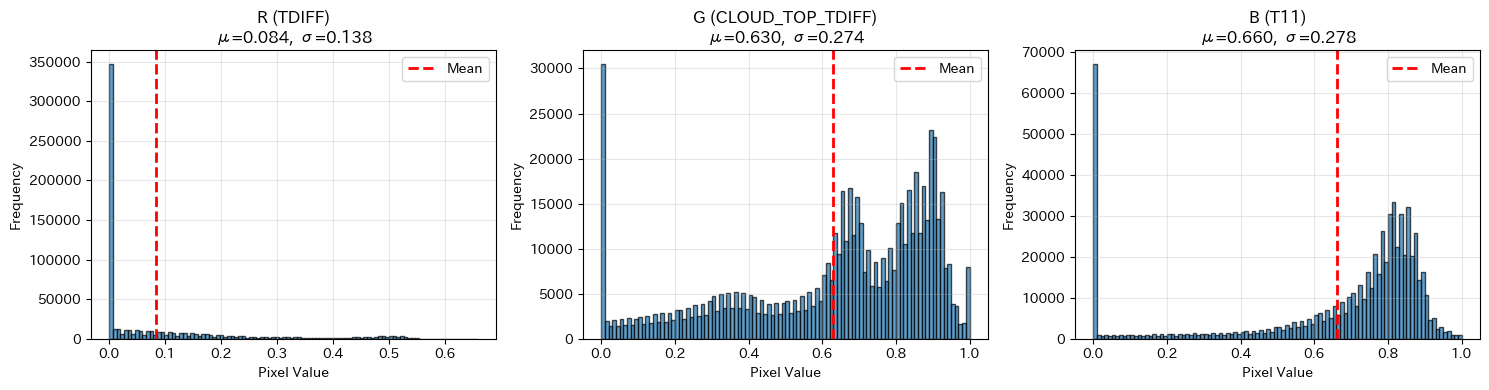

In [12]:
# チャンネル別統計
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['R (TDIFF)', 'G (CLOUD_TOP_TDIFF)', 'B (T11)']

for c in range(3):
    channel_data = batch_imgs[:, c, :, :, :].flatten().numpy()
    axes[c].hist(channel_data, bins=100, edgecolor='black', alpha=0.7)
    axes[c].set_title(f'{channel_names[c]}\nμ={channel_data.mean():.3f}, σ={channel_data.std():.3f}')
    axes[c].set_xlabel('Pixel Value')
    axes[c].set_ylabel('Frequency')
    axes[c].grid(True, alpha=0.3)
    axes[c].axvline(channel_data.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[c].legend()

plt.tight_layout()
plt.show()

## まとめ

本ノートブックでは以下を可視化した:

1. **入力データ**: 3チャンネル×5時系列の偽色画像
   - R: TDIFF (band_15 - band_14)
   - G: CLOUD_TOP_TDIFF (band_14 - band_11)
   - B: T11 (band_14)

2. **Ground Truthマスク**: 飛行機雲領域の二値マスク

3. **モデル出力**: BaseCoatULSTMによるセグメンテーション結果

4. **データ拡張**: Albumentationsによる拡張効果

5. **統計情報**: チャンネル別・バッチ別の分布